# Queries in ITMS Dataset

The following notebook is seperated into 5 parts
1. Pre Processing of ITMS Dataset
2. Selecting H3index
3. Queries
4. Interactive Graphs
5. Calculating Cumulative Epsilon

## 1. Pre Processing the ITMS Dataset

##### We take the following steps to pre-process the data. 
1. Extract Latitude and Longitude values from the location.coordinates attribute
2. Choose the H3 resolution and assign H3 index value to each record (based on Latitude and Longitude values in the record)
3. Convert the observationDatetime string attribute into a datetime python object (to help in processing the record based on the value of the datetime object).
4. Divide a day into Time Slots. Create a column called TimeSlot which will contain the Time Slot at which the data is recorded.
5. Select the records that belong to dates spanning from 15th November 2021 to 15th December 2021 to obtain one month data. 
6. Within this subset, select the records from 'BeginHour' (starting hour of the day for analyzing the data) to 'EndHour'. 
6. Create a column named HAT (to denote Hexagon and Time slot) which denotes a combination of the H3index and the Time Slot. For example, a record having H3 index 8742d9d69ffffff and Time Slot number 20 will have a HAT id as 20-8742d9d69ffffff.


### Loading the dataset

We consider the intelligent transport management system (ITMS) dataset from Surat city for our case study involving differentially private release of statistics. This dataset consists of records generated from transit buses operating in the city. The parameters reported by the buses include licence plate number, instantaneous speed, observationDateTime and location-coordinates (latitude and longitude).

#### Read the raw dataset

In [1]:
import pandas as pd
import numpy as np
import h3
import warnings

warnings.filterwarnings('ignore')

dataNovDec = pd.read_csv('data-NovDec.csv')

#### Compress the Dataset and store it in a csv file

In [2]:
dataNovDec = dataNovDec.loc[:,~dataNovDec.columns.str.match("Unnamed")]
dataNovDec = dataNovDec[['speed','observationDateTime','license_plate','location.coordinates']]

dataNovDec.to_csv('CompressedRawDataset.csv',index=False)
n_tot = len(dataNovDec)
print(n_tot)

13296107


#### Uncomment the below code in case you directly want to load the CompressedDataset.csv file


In [1]:
import pandas as pd
import numpy as np
import h3
import warnings

warnings.filterwarnings('ignore')

dataNovDec = pd.read_csv('https://iudx-cat-sandbox-dev.s3.ap-south-1.amazonaws.com/dp-itms-1/CompressedRawDataset.csv')
n_tot = len(dataNovDec)

### Displaying Dataset

In [2]:
dataNovDec.head()

,speed,observationDateTime,license_plate,location.coordinates
0,16.0,2021-11-15 09:00:13+05:30,GJ05BX3472,"[72.877571, 21.15876]"
1,0.0,2021-11-15 09:00:32+05:30,GJ05BX3472,"[72.876953, 21.15876]"
2,0.0,2021-11-15 09:00:40+05:30,GJ05BX3244,"[72.85242, 21.125909]"
3,26.0,2021-11-15 09:00:41+05:30,GJ05BX2081,"[72.846272, 21.194402]"
4,35.0,2021-11-15 09:00:44+05:30,GJ05BX3399,"[72.861092, 21.186351]"


In [3]:
dataNovDec.tail()

,speed,observationDateTime,license_plate,location.coordinates
13296102,28.0,2021-12-15 20:46:12+05:30,GJ05CU2012,"[72.789559, 21.224388]"
13296103,0.0,2021-12-15 20:46:13+05:30,GJ05CU1366,"[72.870982, 21.175778]"
13296104,2.0,2021-12-15 20:46:13+05:30,GJ05CU2414,"[72.84249, 21.19919]"
13296105,22.0,2021-12-15 20:46:14+05:30,GJ05CU2147,"[72.838805, 21.203108]"
13296106,15.0,2021-12-15 20:46:14+05:30,GJ05CU2192,"[72.863316, 21.150773]"


## User Configurable Parameters

### H3R: H3 Resolution (Higher Resolution implies smaller Hexagon Size)
###### Recommended Values for H3R: 6, 7, 8. 

### TSR_minutes: Time Slot Resolution in minutes (Eg: TSR_minutes = 30 implies each slot is of 30 minutes)
###### Recommended Values for TSR_minutes: 30, 60, 120

### BeginHour: Starting Hour of the day (from when we want to observe the statistics)
### EndHour: Ending Hour of the day (when the observation ends)
###### The BeginHour and EndHour take absolute hour values. Eg. if we are interested in the time range 9am to 9pm, then BeginHour = 9 and EndHour = 21. Recommended Range 9 <= BeginHour < EndHour <= 21


In [5]:
# import json

# configFile = 'configDP.json'
# with open(configFile, 'r') as cfile:
#     dataDict = json.load(cfile)
    
# H3R = dataDict['h3IndexResolution']
# TSR_minutes = dataDict['timeslotResolution']
# BeginHour = dataDict['beginHour']
# EndHour = dataDict['endHour']

H3R = 7
TSR_minutes = 60
BeginHour = 9
EndHour = 21

### Splitting Latitude and Longitude

In [6]:
lat_lon = dataNovDec['location.coordinates']
split_lat_lon = lat_lon.str.strip('[]').str.split(', ')

lon = split_lat_lon.apply(lambda x: x[0])
lat = split_lat_lon.apply(lambda x: x[1])

# print(lat[0])
# print(lon[0])

### Assigning H3index based on latitude and longitude

We use the H3 is a geospatial indexing system (developed by Uber) that partitions the world into hexagonal cells. A latitude and longitude pair can be transformed to a 64-bit H3 index, identifying a hexagonal cell.


We choose resolution as 7 over 6 and 8 as when we use 8 resolution the size of h3indices is smaller and the number of h3indices that are selected is only 11%.We dont prefer resolution 6 as each h3index is approximately 36 km square. Resolution 7 is the best trade off in terms of size of each h3index and number of h3indices that can be selected

In [7]:
h3index = [None]*n_tot

# use the H3 Resolution value (H3R) loaded from the config file
for i in range(n_tot):
    h3index[i] = h3.geo_to_h3(lat=float(lat[i]),lng=float(lon[i]),resolution=H3R)
    


In [8]:
dataNovDec['h3index'] = h3index


In [9]:
dataNovDec.head()

,speed,observationDateTime,license_plate,location.coordinates,h3index
0,16.0,2021-11-15 09:00:13+05:30,GJ05BX3472,"[72.877571, 21.15876]",8742d9894ffffff
1,0.0,2021-11-15 09:00:32+05:30,GJ05BX3472,"[72.876953, 21.15876]",8742d9894ffffff
2,0.0,2021-11-15 09:00:40+05:30,GJ05BX3244,"[72.85242, 21.125909]",8742d9d4bffffff
3,26.0,2021-11-15 09:00:41+05:30,GJ05BX2081,"[72.846272, 21.194402]",8742d98b4ffffff
4,35.0,2021-11-15 09:00:44+05:30,GJ05BX3399,"[72.861092, 21.186351]",8742d98b0ffffff


In [10]:
print(len(pd.unique(dataNovDec['h3index'])))

117


### Splitting the observation Date Time into a Date and Time Column

In [11]:
#dataJanMar['Date'] = pd.to_datetime(dataJanMar['observationDateTime'], errors='coerce')
dataNovDec['Date'] = pd.to_datetime(dataNovDec['observationDateTime']).dt.date
dataNovDec['Time'] = pd.to_datetime(dataNovDec['observationDateTime']).dt.time

dataNovDec.head()

,speed,observationDateTime,license_plate,location.coordinates,h3index,Date,Time
0,16.0,2021-11-15 09:00:13+05:30,GJ05BX3472,"[72.877571, 21.15876]",8742d9894ffffff,2021-11-15,09:00:13
1,0.0,2021-11-15 09:00:32+05:30,GJ05BX3472,"[72.876953, 21.15876]",8742d9894ffffff,2021-11-15,09:00:32
2,0.0,2021-11-15 09:00:40+05:30,GJ05BX3244,"[72.85242, 21.125909]",8742d9d4bffffff,2021-11-15,09:00:40
3,26.0,2021-11-15 09:00:41+05:30,GJ05BX2081,"[72.846272, 21.194402]",8742d98b4ffffff,2021-11-15,09:00:41
4,35.0,2021-11-15 09:00:44+05:30,GJ05BX3399,"[72.861092, 21.186351]",8742d98b0ffffff,2021-11-15,09:00:44


### Select records from "BeginHour" to "EndHour"

In [12]:
dt = dataNovDec['Time']
dataNovDec['hour'] = dt.apply(lambda x: x.hour)
dataNovDec['minute']  = dt.apply(lambda x: x.minute)

# Use the BeginHour and EndHour variables (from the config file) to select the records
dataNovDec = dataNovDec[(dataNovDec['hour']>= BeginHour) & (dataNovDec['hour']< EndHour)]

In [13]:
dataNovDec.head()

,speed,observationDateTime,license_plate,location.coordinates,h3index,Date,Time,hour,minute
0,16.0,2021-11-15 09:00:13+05:30,GJ05BX3472,"[72.877571, 21.15876]",8742d9894ffffff,2021-11-15,09:00:13,9,0
1,0.0,2021-11-15 09:00:32+05:30,GJ05BX3472,"[72.876953, 21.15876]",8742d9894ffffff,2021-11-15,09:00:32,9,0
2,0.0,2021-11-15 09:00:40+05:30,GJ05BX3244,"[72.85242, 21.125909]",8742d9d4bffffff,2021-11-15,09:00:40,9,0
3,26.0,2021-11-15 09:00:41+05:30,GJ05BX2081,"[72.846272, 21.194402]",8742d98b4ffffff,2021-11-15,09:00:41,9,0
4,35.0,2021-11-15 09:00:44+05:30,GJ05BX3399,"[72.861092, 21.186351]",8742d98b0ffffff,2021-11-15,09:00:44,9,0


In [14]:
dataNovDec.tail()

,speed,observationDateTime,license_plate,location.coordinates,h3index,Date,Time,hour,minute
13296102,28.0,2021-12-15 20:46:12+05:30,GJ05CU2012,"[72.789559, 21.224388]",8742d9991ffffff,2021-12-15,20:46:12,20,46
13296103,0.0,2021-12-15 20:46:13+05:30,GJ05CU1366,"[72.870982, 21.175778]",8742d98b2ffffff,2021-12-15,20:46:13,20,46
13296104,2.0,2021-12-15 20:46:13+05:30,GJ05CU2414,"[72.84249, 21.19919]",8742d98b4ffffff,2021-12-15,20:46:13,20,46
13296105,22.0,2021-12-15 20:46:14+05:30,GJ05CU2147,"[72.838805, 21.203108]",8742d98b4ffffff,2021-12-15,20:46:14,20,46
13296106,15.0,2021-12-15 20:46:14+05:30,GJ05CU2192,"[72.863316, 21.150773]",8742d9d49ffffff,2021-12-15,20:46:14,20,46


### Create TimeSlots based on TimeSlotResolution

In [15]:
dataNovDec['TimeStamp'] = (dataNovDec['hour'] - BeginHour)*60 + dataNovDec['minute']

# Use the Time Slot Resolution (TSR_minutes) value loaded from the config file
dataNovDec['TimeSlot'] = dataNovDec['TimeStamp'].floordiv(TSR_minutes, fill_value=0) + 1

dataNovDec.drop(columns = ['hour','minute','TimeStamp','location.coordinates','observationDateTime','Time'], inplace = True)

TotalTimeSlots = np.ceil(((EndHour - BeginHour)*60)/TSR_minutes)
TotalTimeSlots

12.0

### HAT is defined as H3index and Time Slot
#### For example if h3index = 8742d999affffff and Time Slot = 9, the HAT is 9 8742d999affffff

In [16]:
dataNovDec['HAT'] = dataNovDec['TimeSlot'].astype(str) + '-' + dataNovDec['h3index']

In [17]:
dataNovDec.head()

,speed,license_plate,h3index,Date,TimeSlot,HAT
0,16.0,GJ05BX3472,8742d9894ffffff,2021-11-15,1,1-8742d9894ffffff
1,0.0,GJ05BX3472,8742d9894ffffff,2021-11-15,1,1-8742d9894ffffff
2,0.0,GJ05BX3244,8742d9d4bffffff,2021-11-15,1,1-8742d9d4bffffff
3,26.0,GJ05BX2081,8742d98b4ffffff,2021-11-15,1,1-8742d98b4ffffff
4,35.0,GJ05BX3399,8742d98b0ffffff,2021-11-15,1,1-8742d98b0ffffff


In [18]:
dataNovDec.tail()

,speed,license_plate,h3index,Date,TimeSlot,HAT
13296102,28.0,GJ05CU2012,8742d9991ffffff,2021-12-15,12,12-8742d9991ffffff
13296103,0.0,GJ05CU1366,8742d98b2ffffff,2021-12-15,12,12-8742d98b2ffffff
13296104,2.0,GJ05CU2414,8742d98b4ffffff,2021-12-15,12,12-8742d98b4ffffff
13296105,22.0,GJ05CU2147,8742d98b4ffffff,2021-12-15,12,12-8742d98b4ffffff
13296106,15.0,GJ05CU2192,8742d9d49ffffff,2021-12-15,12,12-8742d9d49ffffff


In [19]:
print(len(pd.unique(dataNovDec['HAT'])))

1213


### Splitting the dataset according to our definition
#### The date is set as 15th Novemeber 2021 to 15th December 2021

In [20]:
start_date = pd.to_datetime("2021-11-15").date()
end_date = pd.to_datetime("2021-12-15").date()
data = dataNovDec[(dataNovDec['Date']>= start_date) & (dataNovDec['Date'] <= end_date)]

## 2. Choosing H3index
### Base Condition  = Has average more than 10 Unique Buses Every Day for all Time Slots from 9 am to 9 pm

The H3indices are given below and the number of H3indices are mentioned below too

In [21]:
data1 = data
h3index = data1['h3index'].unique()
print(h3index)
print(len(h3index))


['8742d9894ffffff' '8742d9d4bffffff' '8742d98b4ffffff' '8742d98b0ffffff'
 '8742d98b5ffffff' '8742d9d48ffffff' '8742d999affffff' '8742d98a0ffffff'
 '8742d9d69ffffff' '8742d9c64ffffff' '8742d9998ffffff' '8742d9d09ffffff'
 '8742d9d6effffff' '8742d9d6bffffff' '8742d98b2ffffff' '8742d98a2ffffff'
 '8742d999bffffff' '8742d98b6ffffff' '8742d998affffff' '8742d999cffffff'
 '8742d9992ffffff' '8742d9d61ffffff' '8742d9d65ffffff' '8742d98a3ffffff'
 '8742d9d6dffffff' '8742d9d4dffffff' '8742d9d4cffffff' '8742d9d41ffffff'
 '8742d9d6affffff' '8742d98acffffff' '8742d9991ffffff' '8742d98b1ffffff'
 '8742d9886ffffff' '8742d9993ffffff' '8742d9832ffffff' '8742d9999ffffff'
 '8742d999effffff' '8742d99a5ffffff' '8742d9c62ffffff' '8742d9d63ffffff'
 '8742d9d49ffffff' '8742d98aeffffff' '8742d9d68ffffff' '8742d9c66ffffff'
 '8742d9d6cffffff' '8742d9896ffffff' '8742d98b3ffffff' '8742d989dffffff'
 '8742d9d45ffffff' '8742d9d71ffffff' '8742dd6caffffff' '8742d9982ffffff'
 '8742dd6dcffffff' '8742d98a1ffffff' '8742d98adffff

We groupby the Data by TimeSlot, Date and H3index with the aggregation function counting the number of unique license plate. 'e' dataframe depicts the number of unique buses per TimeSlot, Date and H3index

In [22]:
e = data1.groupby(['h3index','TimeSlot','Date']).agg({'license_plate': 'nunique'}).reset_index()
e.rename(columns = {'license_plate':'NumUniqueBusesDay'}, inplace = True)
e

,h3index,TimeSlot,Date,NumUniqueBusesDay
0,8742d9810ffffff,12,2021-12-15,1
1,8742d9813ffffff,1,2021-11-26,1
2,8742d9814ffffff,1,2021-11-15,2
3,8742d9814ffffff,1,2021-11-16,1
4,8742d9814ffffff,1,2021-11-17,2
...,...,...,...,...
26596,875931073ffffff,6,2021-11-19,1
26597,875931073ffffff,9,2021-11-22,1
26598,8759310ecffffff,9,2021-11-16,1
26599,8759310ecffffff,10,2021-12-05,1


The 'e' dataframe is now grouped as the sum of license_plate across dates. Therefore the dataframe 'f' depicts the sum of unique license plate for 31 days per Time Slot and H3index (HAT)

In [23]:
f = e.groupby(['h3index','TimeSlot']).agg({'NumUniqueBusesDay': 'sum'}).reset_index()
#We will rename the column NumUniqueBusesDay to NumUniqueBusesMonth because 
# we have summed the number of unique buses for the entire month
f.rename(columns = {'NumUniqueBusesDay':'NumUniqueBusesMonth'}, inplace = True)
f

,h3index,TimeSlot,NumUniqueBusesMonth
0,8742d9810ffffff,12,1
1,8742d9813ffffff,1,1
2,8742d9814ffffff,1,25
3,8742d9814ffffff,2,35
4,8742d9814ffffff,3,29
...,...,...,...
1208,875931073ffffff,6,1
1209,875931073ffffff,9,1
1210,8759310ecffffff,9,1
1211,8759310ecffffff,10,1


We expect each HAT to have at least 10 unique license plate per day. Therefore across 31 days, we expect 310 buses at least. The following statement filters out the buses which passes the condition

In [24]:
date = data1['Date'].unique()
min_bus_per_HAT = 10
NumDays = len(date)
NumDays


31

In [25]:
limit = NumDays* min_bus_per_HAT
g = f[f['NumUniqueBusesMonth']>=limit]
g

,h3index,TimeSlot,NumUniqueBusesMonth
160,8742d98a0ffffff,1,684
161,8742d98a0ffffff,2,759
162,8742d98a0ffffff,3,682
163,8742d98a0ffffff,4,514
164,8742d98a0ffffff,5,468
...,...,...,...
1091,8742d9d6effffff,10,576
1092,8742d9d6effffff,11,548
1093,8742d9d6effffff,12,434
1103,8742d9d71ffffff,1,316


For a selected H3index, every timeslot must satisfy the condition of having 310 unique buses across all 31 days. Therefore, we count the number of timeslots in each h3index where this condition is satisfied. We select only those H3 indices for which this condition (of having sufficient number of operating buses in a HAT) is satisfied for all the timeslots. 

In [26]:
h = g.groupby('h3index').agg({'TimeSlot':'count'}).reset_index()
# NumTimeSlots shows the number of Time Slots (for a given H3 index) that has sufficient number of buses 
h.rename(columns = {'TimeSlot':'NumTimeSlots'}, inplace = True)
h

,h3index,NumTimeSlots
0,8742d98a0ffffff,12
1,8742d98a1ffffff,1
2,8742d98a2ffffff,12
3,8742d98a3ffffff,1
4,8742d98a6ffffff,12
5,8742d98b0ffffff,12
6,8742d98b1ffffff,12
7,8742d98b2ffffff,12
8,8742d98b4ffffff,12
9,8742d98b5ffffff,12


In [27]:
i = h[h['NumTimeSlots']==TotalTimeSlots]
i


,h3index,NumTimeSlots
0,8742d98a0ffffff,12
2,8742d98a2ffffff,12
4,8742d98a6ffffff,12
5,8742d98b0ffffff,12
6,8742d98b1ffffff,12
7,8742d98b2ffffff,12
8,8742d98b4ffffff,12
9,8742d98b5ffffff,12
10,8742d98b6ffffff,12
11,8742d998affffff,12


The selected h3index are displayed below

In [28]:
selected = i['h3index']
selected
# print(len(selected))

0     8742d98a0ffffff
2     8742d98a2ffffff
4     8742d98a6ffffff
5     8742d98b0ffffff
6     8742d98b1ffffff
7     8742d98b2ffffff
8     8742d98b4ffffff
9     8742d98b5ffffff
10    8742d98b6ffffff
11    8742d998affffff
12    8742d9991ffffff
13    8742d9993ffffff
14    8742d9998ffffff
15    8742d9999ffffff
16    8742d999affffff
17    8742d999bffffff
20    8742d9d44ffffff
21    8742d9d45ffffff
22    8742d9d48ffffff
23    8742d9d49ffffff
25    8742d9d4cffffff
26    8742d9d4dffffff
27    8742d9d63ffffff
28    8742d9d68ffffff
29    8742d9d69ffffff
30    8742d9d6affffff
31    8742d9d6bffffff
32    8742d9d6cffffff
33    8742d9d6dffffff
34    8742d9d6effffff
Name: h3index, dtype: object

In [29]:
df = data1['h3index'].isin(selected)
data1 = data1[df]

NumUniqueHex = data1.h3index.nunique()
NumUniqueHex

30

In [30]:
data1.head()

,speed,license_plate,h3index,Date,TimeSlot,HAT
3,26.0,GJ05BX2081,8742d98b4ffffff,2021-11-15,1,1-8742d98b4ffffff
4,35.0,GJ05BX3399,8742d98b0ffffff,2021-11-15,1,1-8742d98b0ffffff
5,26.0,GJ05BZ3736,8742d98b5ffffff,2021-11-15,1,1-8742d98b5ffffff
6,20.0,GJ05BX3119,8742d9d48ffffff,2021-11-15,1,1-8742d9d48ffffff
8,0.0,GJ05BX3214,8742d999affffff,2021-11-15,1,1-8742d999affffff


### Save the preprocessed dataset

In [31]:
data1.to_csv('data-NovDec-processed1.csv',index=False)

## If the preprocessed dataset is directly loaded, then run from the following cells

#### Import the necessary libraries and load the preprocessed csv file

In [32]:
import pandas as pd
import numpy as np
import h3

datanew = pd.read_csv('data-NovDec-processed1.csv')
datanew

,speed,license_plate,h3index,Date,TimeSlot,HAT
0,26.0,GJ05BX2081,8742d98b4ffffff,2021-11-15,1,1-8742d98b4ffffff
1,35.0,GJ05BX3399,8742d98b0ffffff,2021-11-15,1,1-8742d98b0ffffff
2,26.0,GJ05BZ3736,8742d98b5ffffff,2021-11-15,1,1-8742d98b5ffffff
3,20.0,GJ05BX3119,8742d9d48ffffff,2021-11-15,1,1-8742d9d48ffffff
4,0.0,GJ05BX3214,8742d999affffff,2021-11-15,1,1-8742d999affffff
...,...,...,...,...,...,...
10919288,28.0,GJ05CU2012,8742d9991ffffff,2021-12-15,12,12-8742d9991ffffff
10919289,0.0,GJ05CU1366,8742d98b2ffffff,2021-12-15,12,12-8742d98b2ffffff
10919290,2.0,GJ05CU2414,8742d98b4ffffff,2021-12-15,12,12-8742d98b4ffffff
10919291,22.0,GJ05CU2147,8742d98b4ffffff,2021-12-15,12,12-8742d98b4ffffff


#### Defining all possible dates

In [33]:
date = datanew['Date'].unique()
timeslot = datanew['TimeSlot'].unique()

In [34]:
date

array(['2021-11-15', '2021-11-16', '2021-11-17', '2021-11-18',
       '2021-11-19', '2021-11-20', '2021-11-21', '2021-11-22',
       '2021-11-23', '2021-11-24', '2021-11-25', '2021-11-26',
       '2021-11-27', '2021-11-28', '2021-11-29', '2021-11-30',
       '2021-12-01', '2021-12-02', '2021-12-03', '2021-12-04',
       '2021-12-05', '2021-12-06', '2021-12-07', '2021-12-08',
       '2021-12-09', '2021-12-10', '2021-12-11', '2021-12-12',
       '2021-12-13', '2021-12-14', '2021-12-15'], dtype=object)

In [35]:
timeslot

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

#### All h3index that are selected are defined here

In [36]:
hindex = datanew['h3index'].unique()
hindex

array(['8742d98b4ffffff', '8742d98b0ffffff', '8742d98b5ffffff',
       '8742d9d48ffffff', '8742d999affffff', '8742d98a0ffffff',
       '8742d9d69ffffff', '8742d9998ffffff', '8742d9d6effffff',
       '8742d9d6bffffff', '8742d98b2ffffff', '8742d98a2ffffff',
       '8742d999bffffff', '8742d98b6ffffff', '8742d998affffff',
       '8742d9d6dffffff', '8742d9d4dffffff', '8742d9d4cffffff',
       '8742d9d6affffff', '8742d9991ffffff', '8742d98b1ffffff',
       '8742d9993ffffff', '8742d9999ffffff', '8742d9d63ffffff',
       '8742d9d49ffffff', '8742d9d68ffffff', '8742d9d6cffffff',
       '8742d9d45ffffff', '8742d9d44ffffff', '8742d98a6ffffff'],
      dtype=object)

#### Copy the dataframe for further processing

In [37]:
df1 = datanew

# 3. Queries
## Query 1 -  Average Speed of Buses Passing through a HAT
### Input - H3index, Time Slot and choice of B
### Output - Average Speed of Bus Passing through the specific H3index, Time Slot with an added Laplace noise with parameter B, Computed Epsilon value for the query

#### avg_query_noise_q1(h3index, timeslot,B)
	Select records where h3index and time slot matches the user input
    
    For each day, calculate the average speed of each bus in the chosen HAT
    
    Calculate the monthly average speed of the HAT as the mean value of the average speed per bus per day  
    
    Define Ni to be the number of unique buses in the chosen HAT on day 'i'
    Define N to be sum of Ni (over all days in a month)
    
	Calculate Sensitivity as (Maximum Speed - Minimum Speed)/N = (65/N) (where a neighboring database allows changes in records of a single user for a given day for the chosen HAT)
    
	Calculate Epsilon as Sensitivity/B
    
    Add Laplacian noise (with parameter B) to the overall average speed of the HAT
    
    Return the noisy monthly average speed and the calculated value of epsilon


### Choice of Laplacian noise parameter B (with corresponding noise variance $2B^2$)
###### Recommended value for B should lie within the interval [0.5, 2]. Laplacian Noise with parameter B implies that more than 95% of the times, the absolute value of the noise sample will be less than 3B

In [38]:
# Epsilon User Per day per HAT: Neighbouring data can change average speed of a bus for a given day for a given HAT
def avg_query_noise_q1(h,t,b):
    
    # Select records where h3index and time slot matches the user input
    d = datanew[(datanew['h3index'] == h ) & (datanew['TimeSlot'] == t)]
    
    #For each day, calculate the average speed of each bus in the chosen HAT
    df1 = d.groupby(['Date','license_plate']).agg({'speed':'mean'}).reset_index()
    
    # Calculate the monthly average speed of the HAT as the mean of the average speeds per bus per day for the chosen HAT  
    MonthlyAvgSpeed = df1['speed'].mean()
    
    # Define Ni to be the number of unique buses in the chosen HAT on day 'i'
    # Define N to be sum of Ni (over all days in a month)
    N = len(df1)
    
    # Calculate Sensitivity as (Maximum Speed - Minimum Speed)/N = (65/N) (where a neighboring database allows changes in records of a single user for a given day for the chosen HAT)
    maxspeed = datanew['speed'].max()
    minspeed = datanew['speed'].min()
    sensitivity = (maxspeed-minspeed)/N
    
    # Calculate Epsilon as Sensitivity/B
    ep = sensitivity/(b)

    # Add Laplacian noise (with parameter B) to the overall average speed of the HAT         
    noise = np.random.laplace(0,b,1)
    NoisyAvgSpeed= MonthlyAvgSpeed + noise
    
    # Fancy print outputs
    bolded_speed = f"\033[1m{NoisyAvgSpeed[0]}\033[0m"
    bolded_ep = f"\033[1m{ep}\033[0m"
    print('----------------------------------')
    print('Noisy Average Speed', bolded_speed)
    print('Epsilon',bolded_ep)
    print('----------------------------------\n')
    
    # Return the noisy monthly average speed and the calculated value of epsilon
    return NoisyAvgSpeed[0],ep


#### Testing the avg_query_noise and thereby executing query 1

In [39]:
#Testing New Approach
[Speed, Epsilon] = avg_query_noise_q1('8742d9d48ffffff',10,0.5)
[Speed, Epsilon] = avg_query_noise_q1('8742d9d48ffffff',10,1)
[Speed, Epsilon] = avg_query_noise_q1('8742d9d48ffffff',10,2)

----------------------------------
Noisy Average Speed 16.320169051814915
Epsilon 0.23049645390070922
----------------------------------

----------------------------------
Noisy Average Speed 16.49537762062364
Epsilon 0.11524822695035461
----------------------------------

----------------------------------
Noisy Average Speed 15.72539977082207
Epsilon 0.057624113475177305
----------------------------------



#### Plot the calculated epsilon values for different B values

In [40]:
import matplotlib.pyplot as plt

def draw_B_eps_graph_q1(h,t,b):
    e = []
     #choice_of_B = [0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.0]
    choice_of_B = np.arange(0.2,2.1,0.1)

    d = datanew[(datanew['h3index'] == h ) & (datanew['TimeSlot'] == t)]
    df1 = d.groupby(['Date','license_plate']).agg({'speed':'mean'}).reset_index()
    # MonthlyAvgSpeed = df1['speed'].mean()
    N = len(df1)
    
    maxspeed = datanew['speed'].max()
    minspeed = datanew['speed'].min() 
    sensitivity = (maxspeed-minspeed)/N
    
    # ep = sensitivity/(b)
    for k in choice_of_B:
        e.append(sensitivity/k)
        
    plt.plot(choice_of_B,e,color='blue',marker='o')
    ep_b = sensitivity/b
    plt.plot(b,ep_b,color='red',marker='o')
    plt.title('B Vs Epsilon')
    plt.xlabel('B')
    plt.ylabel('Epsilon (Privacy Loss)')
    plt.show()
    #return ep_b
    return

In [41]:
def draw_B_var_graph_q1(b):
    #choice_of_B = [0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.0]
    choice_of_B = np.arange(0.2,2.1,0.1)
    variance = list(np.multiply(choice_of_B, choice_of_B)) 
    variance = list(np.array(variance)*2)
    var_b = 2*b*b
    
    #plotting
    plt.plot(choice_of_B, variance, color = 'b', marker ='o')
    plt.plot(b,var_b,color='red',marker='o')
    plt.title('B Vs Noise Variance')
    plt.xlabel('B')
    plt.ylabel('Noise Variance')
    plt.show()
    return

In [42]:
def draw_eps_var_graph_q1(h,t,b):
    e = []
    #choice_of_B = [0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.0]
    choice_of_B = np.arange(0.2,2.1,0.1)

    d = datanew[(datanew['h3index'] == h ) & (datanew['TimeSlot'] == t)]
    df1 = d.groupby(['Date','license_plate']).agg({'speed':'mean'}).reset_index()
    N = len(df1)
    
    maxspeed = datanew['speed'].max()
    minspeed = datanew['speed'].min() 
    sensitivity = (maxspeed-minspeed)/N
    
    # ep = sensitivity/(b)
    for k in choice_of_B :
        e.append(sensitivity/k)

    ep_b = sensitivity/b
    variance = list(np.multiply(choice_of_B, choice_of_B)) 
    variance = list(np.array(variance)*2)
    var_b = 2*b*b
    
    #plotting
    plt.plot(e, variance, color = 'b', marker ='o')
    plt.plot(ep_b,var_b,color='red',marker='o')
    plt.title('Privacy Loss VS Noise Variance')
    plt.xlabel('Epsilon (Privacy Loss)')
    plt.ylabel('Noise Variance')
    plt.show()
    return

## Query 2 -   Average Number of buses per day that exceed a user-specified speed threshold in a given HAT (averaged over the entire month)

### Input - HAT value (H3index and Time Slot), Speed Threshold and choice of B
### Output - Average Number of buses per day that exceed the speed threshold in the chosen HAT. We add Laplacian noise (with parameter B) to the average number of buses that exceed the speed threshold. We return the noisy value of the average number of buses and the calculated Epsilon for the query

#### count_average_buses_noise_q2(h3index, Time Slot, Speed Limit, B)
    Select records where h3index and time slot matches the user input
	
    Calculate the maximum speed for each bus for each day in the selected HAT
    
    Select records that exceed the speed threshold given by the user
    
    Count the number of records (over the entire month) as 'N'
    
    Find the average number of buses per day that exceed the speed threshold by dividing 'N' by number of days in the dataset
    
	Add Laplacian noise (with parameter B) to average number of buses
    
    Compute Sensitivity as 1/(total number of Days in the dataset) where we assume that a neighboring dataset replaces the records of one of the user for one day in the chosen HAT. This corresponds to Epsilon-DP per user per HAT per Day.
    
	Calculate Epsilon = Sensitivity/B
	
    Return the noisy value and epsilon


In [43]:
def count_average_buses_noise_q2(h,t,s,b):
    
    # Select records where h3index and time slot matches the user input
    df1 = datanew[(datanew['h3index']== h) & (datanew['TimeSlot']==t) ]
    
    # Calculate the maximum speed for each bus for each day in the selected HAT
    e= df1.groupby(['license_plate','Date']).agg({'speed':'max'}).reset_index()
    
    # Select records that exceed the speed threshold given by the user
    f= e[(e['speed']>s)]
    
    # Count the number of records (over the entire month) as 'N'
    N = len(f)
    
    # Find the average number of buses per day that exceed the speed threshold by dividing 'N' by number of days in the dataset
    avg_N = N/len(date) 
    
    # Add Laplacian noise (with parameter B) to average number of buses
    noise = np.random.laplace(0,b,1)
    avg_N = avg_N + noise

    # Compute Sensitivity as 1/(total number of Days in the dataset) where we assume that a neighboring dataset replaces the records of one of the user for one day in the chosen HAT. This corresponds to Epsilon-DP per user per HAT per Day.
    sensitivity = 1/len(date)
    
    # Calculate Epsilon = Sensitivity/B
    # Compute Epsilon per user per HAT per Day
    eps = sensitivity/b
    
    avg_N = np.around(avg_N[0])
    
    if(avg_N<0):
        avg_N = +0.0
    
    bolded_num = f"\033[1m{avg_N}\033[0m"
    bolded_ep = f"\033[1m{eps}\033[0m"
    print('----------------------------------------------------------------')
    print('Average Number of Buses Crossing the speed limit', bolded_num)
    print('Epsilon',bolded_ep)
    print('---------------------------------------------------------------')
    return avg_N,eps
    

#### Testing  query 2

In [44]:
count_average_buses_noise_q2("8742d9d48ffffff",10,65,2)

----------------------------------------------------------------
Average Number of Buses Crossing the speed limit 0.0
Epsilon 0.016129032258064516
---------------------------------------------------------------


(0.0, 0.016129032258064516)

In [45]:
def draw_B_eps_graph_q2(b):
    e = []
    #choice_of_B = [0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.0]
    choice_of_B = np.arange(0.2,2.1,0.1)
    sensitivity = 1/len(date)
    for k in choice_of_B:
        e.append(sensitivity/k)
    plt.plot(choice_of_B,e,color='blue',marker='o')
    ep = sensitivity/b
    plt.plot(b,ep,color='red',marker='o')
    plt.title('B vs Epsilon')
    plt.xlabel('B')
    plt.ylabel('Epsilon (Privacy Loss)')
    plt.show()
    return

In [46]:
def draw_eps_var_graph_q2(b):
    e = []
    #choice_of_B = [0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.0]
    choice_of_B = np.arange(0.2,2.1,0.1)
    sensitivity = 1/len(date)
    for k in choice_of_B:
        e.append(sensitivity/k)

    # Compute epsilon for the user specified value of B
    ep_b = sensitivity/b
    
    variance = list(np.multiply(choice_of_B, choice_of_B)) 
    variance = list(np.array(variance)*2)
    var_b = 2*b*b

    plt.plot(e,variance,color='blue',marker='o')

    plt.plot(ep_b,var_b,color='red',marker='o')
    plt.title('Epsilon vs Noise Variance')
    plt.xlabel('Epsilon (Privacy Loss)')
    plt.ylabel('Noise Variance')
    plt.show()
    return

# 4. Using Widgets

Description - Interactive Functions

In [47]:
from ipywidgets import interact
import ipywidgets as widgets

#### Widgets for Query 1

In [48]:
hat = datanew['HAT'].unique()
h3= datanew['h3index'].unique()
time= datanew['TimeSlot'].unique()

In [49]:
import ipywidgets as widgets
from ipywidgets import interact, fixed

h3index_selected = widgets.Dropdown(options = h3, description='H3index')
timeslot_selected = widgets.Dropdown(options=time, description='TimeSlot')
b_selected = widgets.FloatSlider(value=1,min=0.5,max=2,description = 'B')

def test_q1(**kwargs):
    x = kwargs.pop('val')
    if all(kwargs.values()):
#         print('The Selected Values are as follows')
#         bolded_h3 = f"\033[1m{kwargs['h3index_selected']}\033[0m"
#         bolded_ts = f"\033[1m{kwargs['timeslot_selected']}\033[0m"
#         bolded_b = f"\033[1m{kwargs['b_selected']}\033[0m"
#         print('-------------------------------------')
#         print('H3index Selected',bolded_h3)
#         print('Time Slot Selected',bolded_ts)
#         print('B Value Selected',bolded_b)
        print('The Red dot (in the plots below) corresponds to the selected value of B')

        avg_query_noise_q1(kwargs['h3index_selected'],kwargs['timeslot_selected'],kwargs['b_selected'])
        draw_B_eps_graph_q1(kwargs['h3index_selected'],kwargs['timeslot_selected'],kwargs['b_selected'])
        draw_B_var_graph_q1(kwargs['b_selected'])
        draw_eps_var_graph_q1(kwargs['h3index_selected'],kwargs['timeslot_selected'],kwargs['b_selected'])
interact(test_q1, val = fixed(3), h3index_selected=h3index_selected, timeslot_selected=timeslot_selected,b_selected=b_selected);

interactive(children=(Dropdown(description='H3index', options=('8742d98b4ffffff', '8742d98b0ffffff', '8742d98b…

#### Widgets for Query 2

In [60]:
import ipywidgets as widgets
from ipywidgets import interact, fixed

h3index_selected = widgets.Dropdown(options = h3, description='H3index')
timeslot_selected = widgets.Dropdown(options=time, description='TimeSlot')
limit_selected = widgets.BoundedIntText(value=7,min=0,max=65,step=5,description='Speed Limit',disabled=False)
b_selected = widgets.FloatSlider(value=7.5,min=0.5,max=2,description = 'B')

def test_q2(**kwargs):
    x = kwargs.pop('val')
    if all(kwargs.values()):
#         print('The Selected Values are as follows')
#         bolded_h3 = f"\033[1m{kwargs['h3index_selected']}\033[0m"
#         bolded_ts = f"\033[1m{kwargs['timeslot_selected']}\033[0m"
#         bolded_limit = f"\033[1m{kwargs['limit_selected']}\033[0m"
#         bolded_b = f"\033[1m{kwargs['b_selected']}\033[0m"
#         print('-------------------------------------')
#         print('H3index Selected',bolded_h3)
#         print('Time Slot Selected',bolded_ts)
#         print('Limit Selected',bolded_limit)
#         print('B Value Selected',bolded_b)
        print('The Red dot (in the plots below) corresponds to the selected value of B')
        count_average_buses_noise_q2(kwargs['h3index_selected'],kwargs['timeslot_selected'],kwargs['limit_selected'],kwargs['b_selected'])
        draw_B_eps_graph_q2(kwargs['b_selected'])
        draw_eps_var_graph_q2(kwargs['b_selected'])
interact(test_q2, val = fixed(4), h3index_selected=h3index_selected, timeslot_selected=timeslot_selected,limit_selected=limit_selected,b_selected=b_selected);

interactive(children=(Dropdown(description='H3index', options=('8742d98b4ffffff', '8742d98b0ffffff', '8742d98b…

## 5. Cumulative Epsilon (Epsilon Per Day)

Sensitivity is the maximum possible variation in the query output if certain number of records are replaced or omitted by a given user

Epsilon Per HAT Per Day - Sensitivity is calculated for a neighboring dataset that allows changes in the records of a single user for a given Day in a given HAT

Epsilon Per Day - Sensitivity is calculated for a neighboring dataset that allows changes in the records of a single user for a given day for all possible HAT's

#### cumulative_epsilon_query1()
    Let 'K' denote the maximum number of HATs any bus can pass through in a single day
    For Query 1, define Worst Case Epsilon per day as the sum of top ‘K’ worst (largest) epsilon-per-HAT-per-Day values

#### cumulative_epsilon_query2()
    Let 'K' denote the maximum number of HATs any bus can pass through in a single day
    For Query 2, define Worst Case Epsilon per day as the product of 'K' and Epsilon-per-HAT-per-Day


### Query 1 - Average Speed of Buses Passing through a HAT

    Sensitivity is computed as the difference between Maximum Speed achieved by a bus and the minimum speed by a bus over the Sum of Total Number of Unique Buses per day for the given HAT(N)


$$
Sensitivity = \frac {(Maximum Speed -Minimum Speed)}{N}
$$

$$
N = {N_1+N_2…..+N_{31}}
$$

$$
\\
N_i = \mathrm { Number\ of\ Unique\ Buses\ in\ a\ given\ HAT\ on\ Day \ i}
$$

$$
EpsilonPerHATperDay = \frac {Sensitivity}  {B}
$$


    We know that the Maximum Speed and Minimum Speed are constant, therefore the least value of N will give us the largest value of Sensitivity thereby the largest value (or worst case) Epsilon-per-HAT-per-Day


#### cumulative_epsilon_query1()
    Let 'K' denote the maximum number of HATs any bus can pass through in a single day
    For Query 1, define Worst Case Epsilon per day as the sum of top ‘K’ worst Epsilon-per-HAT-per-Day values


In [61]:
df1 = datanew

In [62]:
max_speed = df1['speed'].max()
# min_speed = 0

In [63]:
df2 = df1.groupby(['Date','h3index','TimeSlot']).agg({'license_plate':'nunique'}).reset_index()
df3 = df2.groupby(['h3index','TimeSlot']).agg({'license_plate':'sum'}).reset_index()
df3.rename(columns = {'license_plate':'NumUniqueBusesMonth'}, inplace = True)

# User can select B
B=0.5

df3['Epsilon_q1'] = (max_speed/ df3['NumUniqueBusesMonth'])
df3['Epsilon_q1'] = df3['Epsilon_q1']/B

In [64]:
epsilon_per_HAT_per_Day = df3
max_epsilon_q1 = epsilon_per_HAT_per_Day['Epsilon_q1'].max()

In [65]:
df3['NumUniqueBusesMonth'].min()

314

In [66]:
df3['Epsilon_q1'].max()

0.4140127388535032

In [67]:
df2 = df1.groupby(['Date','license_plate']).agg({'HAT':'nunique'}).reset_index()
df2.rename(columns = {'HAT':'NumUniqueHATsDay'}, inplace = True)
df2


,Date,license_plate,NumUniqueHATsDay
0,2021-11-15,GJ05BU3663,4
1,2021-11-15,GJ05BU8829,27
2,2021-11-15,GJ05BU8836,11
3,2021-11-15,GJ05BU8838,5
4,2021-11-15,GJ05BU8841,43
...,...,...,...
11152,2021-12-15,GJ05CU2568,12
11153,2021-12-15,GJ05CU2718,28
11154,2021-12-15,GJ05CU2891,13
11155,2021-12-15,GJ05bz0313,10


<AxesSubplot:ylabel='Frequency'>

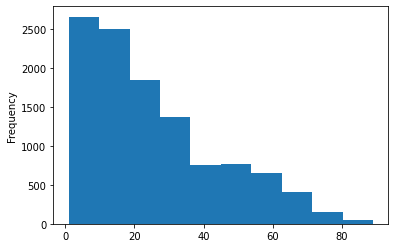

In [68]:
df2['NumUniqueHATsDay'].plot.hist(bins=10)

In [69]:
K = df2['NumUniqueHATsDay'].max()
print(K)

89


In [70]:
epsilon_per_HAT_per_Day

,h3index,TimeSlot,NumUniqueBusesMonth,Epsilon_q1
0,8742d98a0ffffff,1,684,0.190058
1,8742d98a0ffffff,2,759,0.171278
2,8742d98a0ffffff,3,682,0.190616
3,8742d98a0ffffff,4,514,0.252918
4,8742d98a0ffffff,5,468,0.277778
...,...,...,...,...
355,8742d9d6effffff,8,668,0.194611
356,8742d9d6effffff,9,637,0.204082
357,8742d9d6effffff,10,576,0.225694
358,8742d9d6effffff,11,548,0.237226


Sort epsilon_per_HAT_per_Day in descending order of Epsilon_q1

To calculate Epsilon Per Day for Query 1, add the first 'K' number of values of Epsilon_q1 from the sorted epsilon_per_HAT_per_Day dataframe

In [71]:
cumulative_epsilon_q1 = epsilon_per_HAT_per_Day.nlargest(K, "Epsilon_q1")['Epsilon_q1'].sum()
print(K)
print(cumulative_epsilon_q1)

89
24.72216109644188


## Query 2 - Average Number of buses exceeding a user-specified speed threshold for a HAT 

$$
EpsilonPerHATperDay = \frac {1} {Number\ of\ Days \times B}
$$

In [72]:
number_of_days =  len(df1['Date'].unique())
print(number_of_days)

31


In [73]:
# User selects B value
B = 0.5

#  EpsilonPerHATperDay is same for all HATs for Query 2
epsilon_per_HAT_per_Day_q2 = (1/number_of_days)/B
print(epsilon_per_HAT_per_Day_q2)

0.06451612903225806


    For Query 2, we calculate the Epsilon per day by multiplying K (maximum number of HATs a bus travels in a given day) with the calculated epsilon_per_HAT_per_Day_q2

In [74]:
print(K)
cumulative_epsilon_q2 = K * epsilon_per_HAT_per_Day_q2
print(cumulative_epsilon_q2)

89
5.741935483870968


## Cumulative Epsilon (Epsilon Per Day) for both the Queries

$$
Cumulative\ Epsilon = E_1 + E_2
$$

$$
E_1 = Cumulative\ Epsilon\  of\  Query \ 1
\\
\\
E_2 = Cumulative\  Epsilon\  of \ Query \ 2
$$

In [75]:
cumulative_epsilon = cumulative_epsilon_q1 + cumulative_epsilon_q2
print(cumulative_epsilon)

30.464096580312848
